# RFA - Trabajo académico 2

## **1. Pasos previos**

### 1.1 Instalar herramientas necesarias

In [1]:
%%capture
!pip install essentia

### 1.2 Importar librerías

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import timeit

import os
import json

import sys
from tqdm.auto import tqdm
import essentia.standard as es
from essentia import Pool
import sklearn

import random
import librosa
import librosa.display
from IPython.display import Audio

from sklearn.model_selection import train_test_split

### 1.3 Cargar los datos



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/Colab Notebooks/RFA/trabajo2'

data_path = '/content/drive/My Drive/Colab Notebooks/RFA/trabajo2/data'
results_path = '/content/drive/My Drive/Colab Notebooks/RFA/trabajo2/results'

data  results  RFA-Trabajo2.ipynb  RFA-Trabajo2-prueba.ipynb


In [5]:
# Comprobar que se ha guardado bien el dataset en Drive
isData = os.path.isdir(data_path + "/" + "IRMAS_Data")
if(not isData):
  print("An error occured when searching for the Data directory, please download it and include it at /content/drive/My Drive/Colab Notebooks/RFA/trabajo2/IRMAS_Data")
  print("Data link: https://drive.google.com/drive/folders/1PCZbU3EFrr0Ek2II3MtZ8QsX-o3S0cMA?usp=sharing")
  sys.exit()
else:
  print("IRMAS_Data correctly loaded")

IRMAS_Data correctly loaded


## **2. Preproceso de datos**

Guardar los datos de los ficheros

In [6]:
class_mapping = {
  'voi':0,
  'vio':1,
  'tru':2,
  'sax':3,
  'pia':4,
  'org':5,
  'gel':6,
  'gac':7,
  'flu':8,
  'cla':9,
  'cel':10
}

In [7]:
audio_files = {}
for c in class_mapping.keys(): # para cada clase
  # obtener todos sus archivos de audio asociados
  files = [filename for filename in os.listdir(data_path + "/IRMAS_Data" + "/" + c + "/")]
  audio_files[c] = files

In [8]:
# guardar un fichero json
if False:
  with open(data_path +'/' + 'data_instruments.json', 'w') as outfile:
      json.dump(audio_files, outfile)

## 2.1 Espectrograma de Mel

### 2.1.1 Funciones para el preproceso

In [9]:
def pad(l, sr):
    # 0-Pad 10 sec at fs hz and add little noise
    z = np.zeros(10*sr, dtype='float32')
    z[:l.size] = l
    z = z + 5*1e-4*np.random.rand(z.size).astype('float32')
    return z

In [10]:
def compute_spectrogram(filename, sr=16000, n_mels=64):
    audio = es.MonoLoader(filename=filename,sampleRate=sr)()
    audio = pad(audio, sr)

    # essentia extractor
    windowing = es.Windowing(type='hann', normalized=False, zeroPadding=0)
    spectrum = es.Spectrum()
    melbands = es.MelBands(numberBands=n_mels,
                           sampleRate=sr,
                           lowFrequencyBound=0,
                           highFrequencyBound=8000,
                           inputSize=(2048)//2+1,
                           weighting='linear',
                           normalize='unit_tri',
                           warpingFormula='slaneyMel',
                           type='power')

    norm10k = es.UnaryOperator(type='identity', shift=0, scale=1)
    log10 = es.UnaryOperator(type='log10')
    results = Pool()

    for frame in es.FrameGenerator(audio, frameSize=1024, hopSize=512, startFromZero=False):
        spectrumFrame = spectrum(windowing(frame))
        results.add('melbands', log10(norm10k(melbands(spectrumFrame))))

    mel_log_spectrum = results['melbands']
    return mel_log_spectrum[:64].T

Ejemplo de extracción de espectrograma

In [11]:
# seleccionar un archivo aleatorio
random_instrument = random.choice(list(class_mapping.keys()))
rand_sound = random.choice(audio_files[random_instrument])
data_rand_instrument = data_path + "/IRMAS_Data" + '/' + random_instrument + '/'

Filename: 047__[cla][nod][cla]0247__3.wav


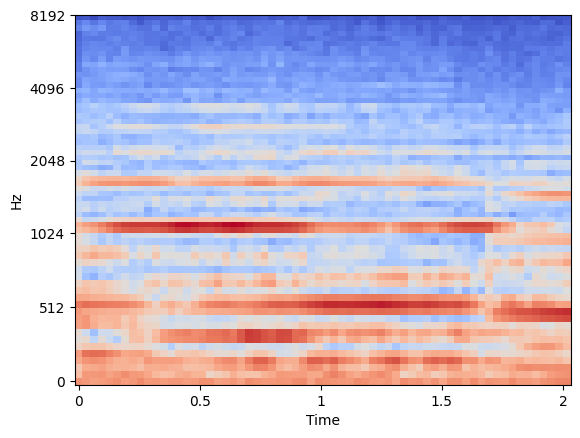

In [12]:
# calcular el espectrograma y reproducir el audio
x = compute_spectrogram(f'{data_rand_instrument}/{rand_sound}')
librosa.display.specshow(x, sr=16000, x_axis='time', y_axis='mel')

print("Filename: " + rand_sound)
Audio(f'{data_rand_instrument}/{rand_sound}')

### 2.1.2 Calcular espectrograma para todos los datos

In [11]:
if False: # poner a True si fuera necesario repetir el preproceso
    dataset = json.load(open(data_path+'/data_instruments.json', 'rb'))
    num_sounds = sum([len(v) for _, v in dataset.items()])
    num_classes = len(dataset)

    specs = np.zeros((num_sounds, 64, 64))
    labels = np.zeros((num_sounds,))

    idx = 0

    with tqdm(total=num_sounds) as pbar:
        for class_name, sounds in dataset.items():
            for sound in sounds:
                specs[idx] = compute_spectrogram(f'{data_path}/IRMAS_Data/{class_name}/{sound}')
                labels[idx] = class_mapping[class_name]
                idx += 1
                pbar.update()

    np.save(data_path+'/specs_mel.npy', specs)
    np.save(data_path+'/labels_mel.npy', labels)

## 2.2 Centroide espectral

### 2.2.1 Funciones para el preproceso

In [12]:
def compute_spectral_centroid(filename, sr=16000):
    audio, _ = librosa.load(filename, sr=sr)
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)
    return spectral_centroids

In [13]:
def compute_scen(filename, sr=16000):
    spectral_centroids = compute_spectral_centroid(filename, sr=sr)
    return spectral_centroids

Ejemplo de extracción de centroide espectral

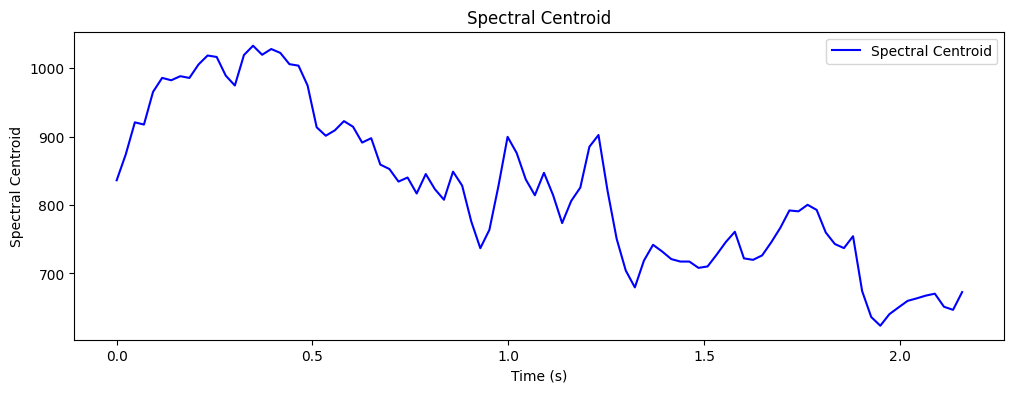

Filename: 047__[cla][nod][cla]0247__3.wav


In [16]:
# calcular el centroide espectral y reproducir el audio
spectral_centroid = compute_scen(f'{data_rand_instrument}/{rand_sound}')
# Crear un eje de tiempo para el Spectral Centroid
time_axis = librosa.times_like(spectral_centroid)
# Crear una gráfica de línea para el Spectral Centroid
plt.figure(figsize=(12, 4))
plt.plot(time_axis, spectral_centroid[0], label='Spectral Centroid', color='b')
plt.title("Spectral Centroid")
plt.xlabel('Time (s)')
plt.ylabel('Spectral Centroid')
plt.legend()
plt.show()

print("Filename: " + rand_sound)
Audio(f'{data_rand_instrument}/{rand_sound}')

### 2.2.2 Calcular el centroide espectral para todos los datos

In [17]:
if False: # poner a True si fuera necesario repetir el preproceso
    dataset = json.load(open(data_path+'/data_instruments.json', 'rb'))
    num_sounds = sum([len(v) for _, v in dataset.items()])
    num_classes = len(dataset)

    specs = np.zeros((num_sounds, 1, 94))
    labels = np.zeros((num_sounds,))

    idx = 0

    with tqdm(total=num_sounds) as pbar:
        for class_name, sounds in dataset.items():
            for sound in sounds:
                specs[idx] = compute_spectrogram(f'{data_path}/IRMAS_Data/{class_name}/{sound}')
                labels[idx] = class_mapping[class_name]
                idx += 1
                pbar.update()

    np.save(data_path+'/specs_sce.npy', specs)
    np.save(data_path+'/labels_sce.npy', labels)

## **3. Obtención de los datos a usar**

### 3.1 Datos con espectrograma

In [83]:
if False: # poner a True si se quiere preprocesar con espectrograma
  specs = np.load(data_path+'/specs_mel.npy')
  labels = np.load(data_path+'/labels_mel.npy')

  specs = specs.reshape(-1, 64, 64, 1)
  specs = (specs - np.mean(specs)) / np.std(specs)

  # partir train y test
  X_train, X_test, y_train, y_test = train_test_split(specs, labels, test_size=0.2, random_state=42)
  print(X_train.shape)
  print(X_test.shape)

  print("Hay " + str(len(X_train)) + " muestras de entrenamiento y " + str(len(X_test))+ " muestras de test.")

(5364, 64, 64, 1)
(1341, 64, 64, 1)
Hay 5364 muestras de entrenamiento y 1341 muestras de test.


### 3.2 Datos con centroide espectral

In [97]:
if True: # poner a True si se quiere preprocesar con centroide espectral
  specs = np.load(data_path+'/specs_sce.npy')
  labels = np.load(data_path+'/labels_sce.npy')

  # specs = specs.reshape(-1, 1, 94)
  specs = specs.reshape(-1, 94) #para poder dibujarlos
  specs = (specs - np.mean(specs)) / np.std(specs)

  # partir train y test
  X_train, X_test, y_train, y_test = train_test_split(specs, labels, test_size=0.2, random_state=42)
  print(X_train.shape)
  print(X_test.shape)

  print("Hay " + str(len(X_train)) + " muestras de entrenamiento y " + str(len(X_test))+ " muestras de test.")
  print(X_train.shape)

(5364, 94)
(1341, 94)
Hay 5364 muestras de entrenamiento y 1341 muestras de test.
(5364, 94)


### 3.3 Creación del Dataset

In [101]:
# creacion de una clase para el datases
class IRMAS(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train):
        self.data = torch.from_numpy(X_train.astype(float))
        self.labels = torch.from_numpy(y_train.astype(float)).squeeze()

    def __getitem__(self, index):
        data = self.data[index]
        lbl = self.labels[index]
        # data = np.transpose(data, axes=[2,0,1]) # descomentar si espectrograma

        return data,lbl
        pass

    def __len__(self):
        return len(self.data)

In [102]:
# instanciar el dataset para el training
# EJECUTAR PARA CADA PREPROCESO
IRMAS_train = IRMAS(X_train, y_train)
example_loader = train_loader = torch.utils.data.DataLoader(dataset=IRMAS_train,
                                               batch_size=8,
                                               shuffle=True)

IRMAS_test = IRMAS(X_test, y_test)
test_loader = torch.utils.data.DataLoader(dataset=IRMAS_test,
                                               batch_size=8,
                                               shuffle=True)

In [18]:
# ejemplo de uso del loader de datos, se extraen algunos espectrogramas
if False:
  for images, labels in example_loader:
    print(images.shape, labels.shape)
    for img,lbl in zip(images,labels):
      print('lbl : ',lbl)
      librosa.display.specshow(img.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
      plt.show()
    break

In [17]:
# ejemplo de uso del loader de datos, se extraen algunos centroides espectrales
if False:
  for images, labels in example_loader:
    print(images.shape, labels.shape)
    for img,lbl in zip(images,labels):
      print('lbl : ',lbl)
      # Crear un eje de tiempo para el Spectral Centroid
      time_axis = librosa.times_like(img)
      # Crear una gráfica de línea para el Spectral Centroid
      plt.figure(figsize=(12, 4))
      plt.plot(time_axis, img, label='Spectral Centroid', color='b')
      plt.title("Spectral Centroid")
      plt.xlabel('Time (s)')
      plt.ylabel('Spectral Centroid')
      plt.legend()
      plt.show()

      print("Filename: " + str(lbl))
    break

## **4. Definición de los modelos**

### 4.1 Red VGG (espectrograma)

In [66]:
class VGG(nn.Module):
    def __init__(self, num_classes=11):

        super(VGG, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch3 = nn.BatchNorm2d(64)


        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batch5 = nn.BatchNorm2d(128)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.batch6 = nn.BatchNorm1d(2*2*128)
        self.fc1 = nn.Linear(2*2*128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)

        self.dropout2d = nn.Dropout2d(0.05)

    def forward(self, x):

        out = self.relu(self.conv1(x))
        out = self.batch1(out)
        out = self.maxpool(out)

        out = self.relu(self.conv2(out))
        out = self.batch2(out)
        out = self.maxpool(out)

        out = self.relu(self.conv3(out))
        out = self.batch3(out)
        out = self.maxpool(out)

        out = self.relu(self.conv4(out))
        out = self.batch4(out)
        out = self.maxpool(out)

        out = self.relu(self.conv5(out))
        out = self.batch5(out)
        out = self.maxpool(out)

        out = out.view(out.size(0), -1)

        out = self.dropout(out)

        out = self.batch6(out)

        out = self.relu(self.fc1(out))

        out = self.softmax(self.fc2(out))

        return out

In [67]:
# instanciar el modelo
vgg = VGG()
vgg = vgg.cuda()

### 4.2 Simple CNN (espectrograma)

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [29]:
# instanciar el modelo
cnn = SimpleCNN(num_classes=11)

### 4.3 Modelo simple (centroide espectral)

In [30]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size=94, hidden_size=128, num_classes=11):
        super(SimpleClassifier, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.softmax(out)

        return out

In [31]:
# instanciar el modelo
simpleModel = SimpleClassifier(input_size=94, hidden_size=128, num_classes=11)

### 4.4 Red VGG (centroide espectral)

In [127]:
class VGG2(nn.Module):
    def __init__(self, num_classes=11):

        super(VGG2, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm1d(32)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch3 = nn.BatchNorm1d(64)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch4 = nn.BatchNorm1d(128)

        self.conv5 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batch5 = nn.BatchNorm1d(128)

        self.relu = nn.ReLU()

        self.maxpool= nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * (94 // 2**5), 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self,x):
        out = self.relu(self.conv1(x))
        out = self.batch1(out)
        out = self.maxpool(out)

        out = self.relu(self.conv2(out))
        out = self.batch2(out)
        out = self.maxpool(out)

        out = self.relu(self.conv3(out))
        out = self.batch3(out)
        out = self.maxpool(out)

        out = self.relu(self.conv4(out))
        out = self.batch4(out)
        out = self.maxpool(out)

        out = self.relu(self.conv5(out))
        out = self.batch5(out)
        out = self.maxpool(out)

        out = out.view(out.size(0), -1)

        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [128]:
# instanciar el modelo
vgg2 = VGG2()

## **5. Entrenamiento**

### 5.1 Para VGG (espectrograma)

In [ ]:
if False:
  vgg.train()
  total_step = len(train_loader)

  loss_list = []

  # Cross entropy loss
  criterion = nn.CrossEntropyLoss()

  # Optimizador Adam
  learning_rate = .001
  optimizer = torch.optim.Adam(vgg.parameters(),lr = learning_rate)

  # Escoger GPU si está disponible
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  num_epochs = 40

  for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device).float()
      labels = labels.to(device).long()

      # Forward
      outputs = vgg(images)
      loss = criterion(outputs, labels.long())
      total_loss+=loss

      # Backward y optimizar
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i+1) % 20 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
              .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    avg_loss = total_loss/total_step
    loss_list.append(avg_loss)

  # torch.save(vgg.state_dict(), results_path+'/vgg_model_mel.ckpt')

  # mostrar evolucion
  plt.figure(figsize=(10, 8))
  plt.title("Loss vs iterations")
  plt.ylabel("Loss")
  plt.xlabel("Iteration")
  plt.plot([tensor.item() for tensor in loss_list])
  plt.show()

### 5.2 Para CNN simple (espectrograma)

Epoch [1/40], Step [20/671], Loss: 2.3675
Epoch [1/40], Step [40/671], Loss: 2.3512
Epoch [1/40], Step [60/671], Loss: 2.4180
Epoch [1/40], Step [80/671], Loss: 2.4180
Epoch [1/40], Step [100/671], Loss: 2.4180
Epoch [1/40], Step [120/671], Loss: 2.5430
Epoch [1/40], Step [140/671], Loss: 2.5430
Epoch [1/40], Step [160/671], Loss: 2.4180
Epoch [1/40], Step [180/671], Loss: 2.2930
Epoch [1/40], Step [200/671], Loss: 2.2930
Epoch [1/40], Step [220/671], Loss: 2.5430
Epoch [1/40], Step [240/671], Loss: 2.1679
Epoch [1/40], Step [260/671], Loss: 2.5425
Epoch [1/40], Step [280/671], Loss: 2.4179
Epoch [1/40], Step [300/671], Loss: 2.2930
Epoch [1/40], Step [320/671], Loss: 2.4180
Epoch [1/40], Step [340/671], Loss: 2.5430
Epoch [1/40], Step [360/671], Loss: 2.5428
Epoch [1/40], Step [380/671], Loss: 2.5428
Epoch [1/40], Step [400/671], Loss: 2.5409
Epoch [1/40], Step [420/671], Loss: 2.4180
Epoch [1/40], Step [440/671], Loss: 2.5430
Epoch [1/40], Step [460/671], Loss: 2.2930
Epoch [1/40], S

AttributeError: ignored

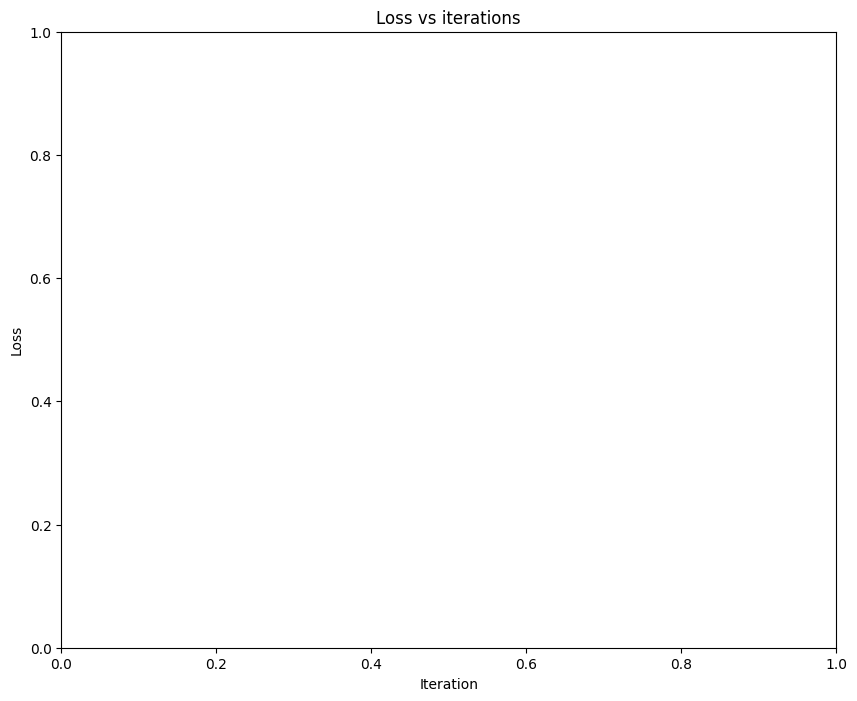

In [91]:
if False:
  cnn.train()
  total_step = len(train_loader)

  loss_list = []

  # Cross entropy loss
  criterion = nn.CrossEntropyLoss()

  # Optimizador Adam
  optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

  num_epochs = 40
  for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
      images = images.float()
      labels = labels.long()

      # Forward
      outputs = cnn(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item()

      # Backward y optimizar
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i + 1) % 20 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
              .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    avg_loss = total_loss / total_step
    loss_list.append(avg_loss)
    print('Epoch [{}/{}], Average Loss: {:.4f}'.format(epoch + 1, num_epochs, avg_loss))

  torch.save(cnn.state_dict(), results_path + '/cnn_model_mel.ckpt')

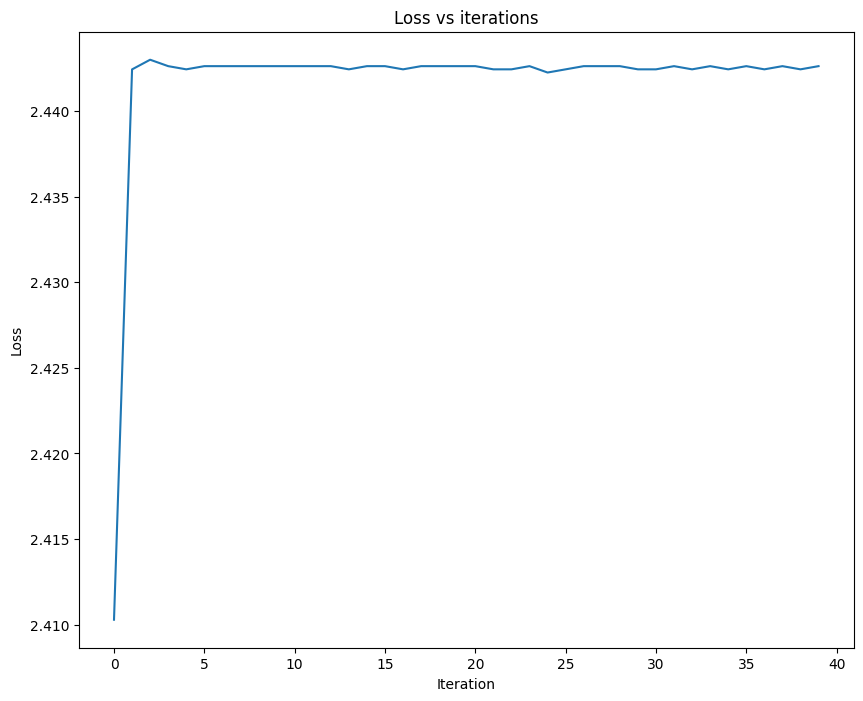

In [92]:
  # mostrar evolucion
  plt.figure(figsize=(10, 8))
  plt.title("Loss vs iterations")
  plt.ylabel("Loss")
  plt.xlabel("Iteration")
  plt.plot([tensor for tensor in loss_list])
  plt.show()

### 5.3 Modelo simple (centroide espectral)

In [103]:
if False:
  simpleModel.train()
  total_step = len(train_loader)

  loss_list = []

  # perdida y optimizador
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(simpleModel.parameters(), lr=0.001)

  num_epochs = 30
  for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
      images = images.float()
      labels = labels.long()

      # Forward
      outputs = simpleModel(images)
      loss = criterion(outputs, labels)
      total_loss += loss

      # Backward y optimizador
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(example_loader)}], Loss: {loss.item():.4f}')

    avg_loss = total_loss/total_step
    loss_list.append(avg_loss)

  torch.save(simpleModel.state_dict(), results_path + '/simple_model_scen.ckpt')

Epoch [1/30], Step [100/671], Loss: 1.8869
Epoch [1/30], Step [200/671], Loss: 2.1599
Epoch [1/30], Step [300/671], Loss: 2.2770
Epoch [1/30], Step [400/671], Loss: 2.3729
Epoch [1/30], Step [500/671], Loss: 2.0441
Epoch [1/30], Step [600/671], Loss: 1.8822
Epoch [2/30], Step [100/671], Loss: 2.3967
Epoch [2/30], Step [200/671], Loss: 2.2839
Epoch [2/30], Step [300/671], Loss: 2.0494
Epoch [2/30], Step [400/671], Loss: 2.3153
Epoch [2/30], Step [500/671], Loss: 2.4157
Epoch [2/30], Step [600/671], Loss: 2.2105
Epoch [3/30], Step [100/671], Loss: 2.1155
Epoch [3/30], Step [200/671], Loss: 2.0705
Epoch [3/30], Step [300/671], Loss: 2.3041
Epoch [3/30], Step [400/671], Loss: 2.2528
Epoch [3/30], Step [500/671], Loss: 2.2831
Epoch [3/30], Step [600/671], Loss: 2.2977
Epoch [4/30], Step [100/671], Loss: 2.1867
Epoch [4/30], Step [200/671], Loss: 1.8303
Epoch [4/30], Step [300/671], Loss: 2.2829
Epoch [4/30], Step [400/671], Loss: 2.1571
Epoch [4/30], Step [500/671], Loss: 2.1798
Epoch [4/30

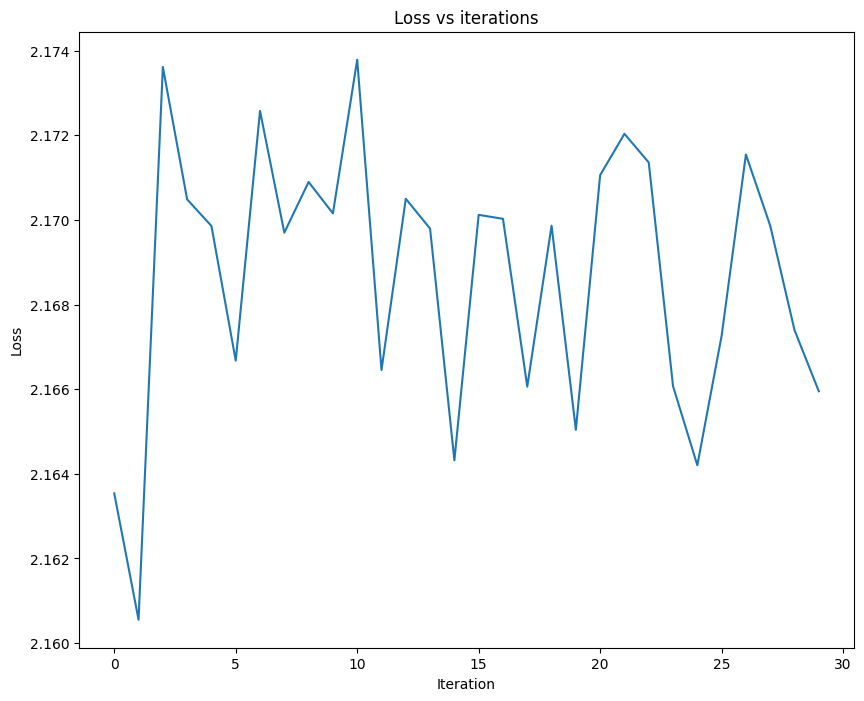

In [104]:
  # mostrar evolucion
  plt.figure(figsize=(10, 8))
  plt.title("Loss vs iterations")
  plt.ylabel("Loss")
  plt.xlabel("Iteration")
  plt.plot([tensor.item() for tensor in loss_list])
  plt.show()

### 5.4 VGG-2 (centroide espectral)

In [130]:
if True:
  vgg2.train()
  total_step = len(train_loader)

  loss_list = []

  # perdida y optimizador
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(vgg2.parameters(),lr = 0.001)

  num_epochs = 40
  for epoch in range(num_epochs):
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
      images = images.reshape(-1, 1, 94)
      images = images.float()
      labels = labels.long()

      # Forward
      outputs = vgg2(images)
      loss = criterion(outputs, labels.long())
      total_loss+=loss.item()

      # Backward y optimizar
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i+1) % 20 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
               .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    avg_loss = total_loss/total_step
    loss_list.append(avg_loss)

  torch.save(vgg2.state_dict(), results_path+'/vgg_model_scen.ckpt')

Epoch [1/40], Step [20/671], Loss: 1.1147
Epoch [1/40], Step [40/671], Loss: 0.7772
Epoch [1/40], Step [60/671], Loss: 1.0008
Epoch [1/40], Step [80/671], Loss: 0.6400
Epoch [1/40], Step [100/671], Loss: 0.7576
Epoch [1/40], Step [120/671], Loss: 0.6574
Epoch [1/40], Step [140/671], Loss: 1.4986
Epoch [1/40], Step [160/671], Loss: 0.8437
Epoch [1/40], Step [180/671], Loss: 0.6668
Epoch [1/40], Step [200/671], Loss: 1.3574
Epoch [1/40], Step [220/671], Loss: 1.2345
Epoch [1/40], Step [240/671], Loss: 0.6682
Epoch [1/40], Step [260/671], Loss: 1.0541
Epoch [1/40], Step [280/671], Loss: 0.7604
Epoch [1/40], Step [300/671], Loss: 0.9809
Epoch [1/40], Step [320/671], Loss: 1.5700
Epoch [1/40], Step [340/671], Loss: 0.6789
Epoch [1/40], Step [360/671], Loss: 0.5166
Epoch [1/40], Step [380/671], Loss: 1.4045
Epoch [1/40], Step [400/671], Loss: 0.9803
Epoch [1/40], Step [420/671], Loss: 0.8183
Epoch [1/40], Step [440/671], Loss: 0.9040
Epoch [1/40], Step [460/671], Loss: 0.3752
Epoch [1/40], S

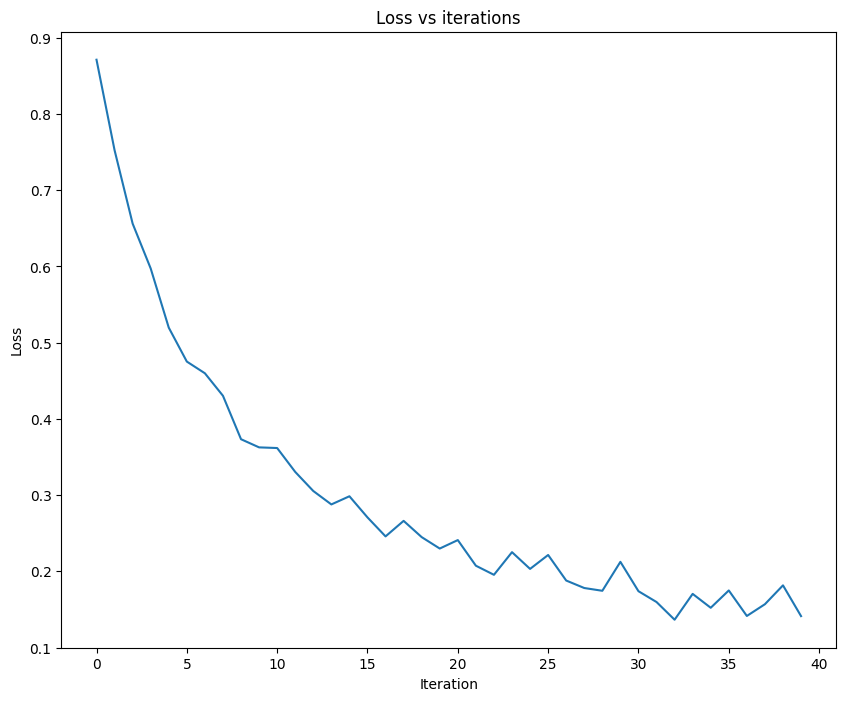

In [132]:
  # mostrar evolucion
  plt.figure(figsize=(10, 8))
  plt.title("Loss vs iterations")
  plt.ylabel("Loss")
  plt.xlabel("Iteration")
  plt.plot([tensor for tensor in loss_list])
  plt.show()

## **6. Evaluación**

### 6.1 Para VGG

In [95]:
if False:
    # cargar el modelo
    vgg.load_state_dict(torch.load(results_path+'/vgg_model_mel.ckpt'))
    # cargar dataset
    IRMASTest = IRMAS(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(dataset=IRMASTest,
                                               batch_size=16,
                                               shuffle=True)
    vgg.eval() # indiciar el modo evaluacion

    # calcular accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.float()
            labels = labels.float()

            outputs = vgg(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the ' + str(len(X_test)) +  ' test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 1341 test images: 58.165548098434 %


### 6.2 Para CNN simple

In [96]:
if False:
  # cargar el modelo
  cnn.load_state_dict(torch.load(results_path+'/cnn_model_mel.ckpt'))

  cnn.eval() # indiciar el modo evaluacion

  # calcular accuracy
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.float()
          labels = labels.long()

          outputs = cnn(images)

          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Test Accuracy of the model on the' + str(len(X_test)) +  ' test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the1341 test images: 10.663683818046234 %


### 6.3 Modelo simple (centroide espectral)



In [106]:
if False:
    # cargar el modelo
    simpleModel.load_state_dict(torch.load(results_path+'/simple_model_scen.ckpt'))
    simpleModel.eval() # indiciar el modo evaluacion

    # calcular accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.float()
            labels = labels.long()

            outputs = simpleModel(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the ' + str(len(X_test)) +  ' test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 1341 test images: 24.60850111856823 %


### 6.4 VGG-2 (centroide espectral)

In [134]:
if True:
    # cargar el modelo
    vgg2.load_state_dict(torch.load(results_path+'/vgg_model_scen.ckpt'))
    vgg2.eval() # indiciar el modo evaluacion

    # calcular accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.float()
            labels = labels.long()

            outputs = simpleModel(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the ' + str(len(X_test)) +  ' test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 1341 test images: 24.086502609992543 %
